# Base Tumor Growth Inhibition Models

Basic simulations of the TGI model, in different parameter regimes.

## Tumor Growth Inhibition (TGI) Model

In general, TGI models represent the change in tumor size ($V$) over time as a net growth effect, with the natural growth rate $\lambda$ modified by a drug‐induced decay effect (with rate $\gamma$). Specifically, we model decaying drug response, with the tumor evolving resistance to the drug at a speed $\epsilon$:

$$
\frac{dV}{dt} = \lambda V - \gamma V \quad,\quad \frac{d \gamma}{dt} = - \epsilon \gamma

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from treatment_sequencing import GrowthInhibitionModel


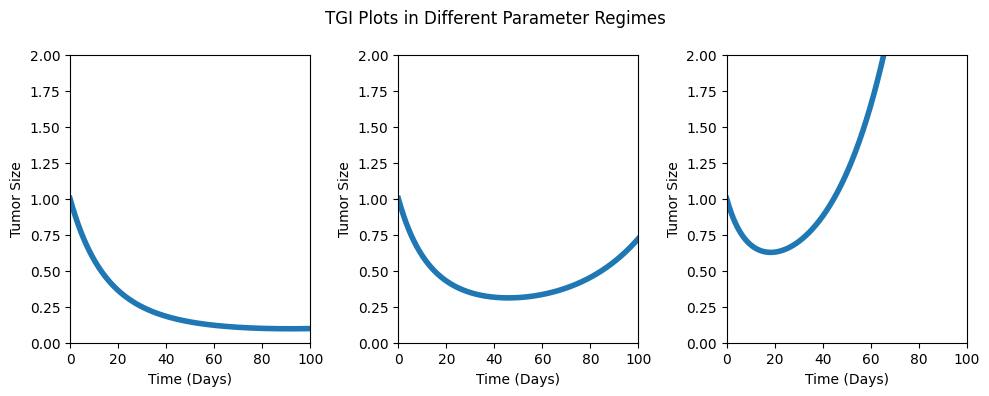

In [14]:
V0 = 1; gamma0 = 0.1; t_max = 100
lambda_vals = [0.04, 0.04, 0.04]
epsilon_vals = [0.01, 0.02, 0.05]

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for i, ax in enumerate(axs):
    params = {'lambda': lambda_vals[i], 'epsilon': epsilon_vals[i], 'V0': V0, 'gamma0': gamma0}
    model = GrowthInhibitionModel(params=params, method='Radau', dt = 0.11)
    model.simulate(t_max=t_max)
    model.plot(ax=ax, linewidth=4)
    ax.set_ylim([0, 2]); ax.set_xlim(0, t_max)
    
plt.suptitle("TGI Plots in Different Parameter Regimes"); plt.tight_layout()

In [3]:
def find_intersection_index(series, val):
    # Find the closest index of a series to a given value.
    # Assumes a monotonic series (will find first crossing otherwise)
    
    series_diff = series - val
    if series.iloc[0] < val:  # Transform series so it decreases to value
        series_diff *= -1
        
    return series_diff.lt(0).idxmax()

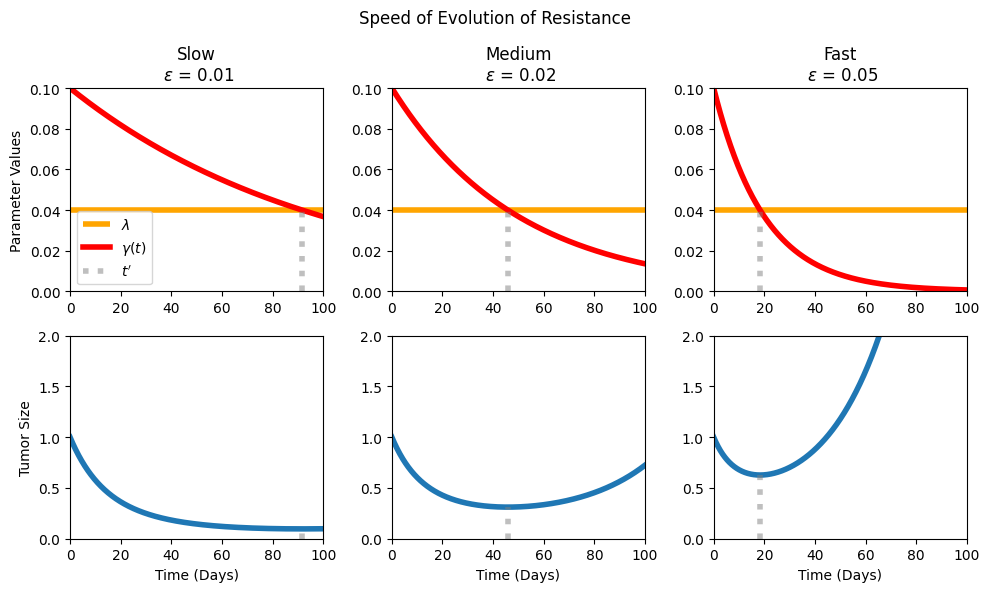

In [18]:
titles = ['Slow', 'Medium', 'Fast']
lw = 4  # Linewidth parameter

fig, axs = plt.subplots(2, 3, figsize=(10, 6))

for i, title in enumerate(titles):
    params = {'lambda': lambda_vals[i], 'epsilon': epsilon_vals[i], 'V0': V0, 'gamma0': gamma0}
    model = GrowthInhibitionModel(params=params, method='Radau', dt = 0.11)
    model.simulate(t_max=t_max)
    model.plot(ax=axs[1][i], linewidth=lw, decorate_axes=False)
    axs[1][i].set_xlabel('Time (Days)')
    
    axs[0][i].set_ylim([0, gamma0]); axs[0][i].set_xlim(0, t_max)
    axs[1][i].set_ylim([0, 2 * V0]); axs[1][i].set_xlim(0, t_max)
    
    axs[0][i].hlines(xmin=0, xmax=t_max, y=lambda_vals[i], linewidth=lw, color='orange', label = r"$\lambda$")
    axs[0][i].plot(model.results_df.Time, model.results_df.gamma, linewidth=lw, color='r', label = r"$\gamma(t)$")
    axs[0][i].set_title(title + f"\n $\epsilon$ = {epsilon_vals[i]}")
    
    intersection_index = find_intersection_index(model.results_df.gamma, lambda_vals[i])
    axs[0][i].vlines(ymin=0, ymax=lambda_vals[i], x=model.results_df.Time.iloc[intersection_index],
                     linewidth=lw, linestyle=':', color='gray', alpha=0.5, label = r"$t^{\prime}$")
    axs[1][i].vlines(ymin=0, ymax=model.results_df.V.iloc[intersection_index], x=model.results_df.Time.iloc[intersection_index],
                     linewidth=lw, linestyle=':', color='gray', alpha=0.5)
    
axs[0][0].legend(loc=3); axs[0][0].set_ylabel('Parameter Values') ; axs[1][0].set_ylabel('Tumor Size')  
plt.suptitle("Speed of Evolution of Resistance"); plt.tight_layout()
plt.savefig("images/TGI_evolution_speed.png")

## Analytic solution

The base TGI model can be solved analytically, to give a total tumor volume of:

$$
V(t) = V_{0} \,exp \Bigl(\lambda t + \frac{\gamma_{0}}{\epsilon}(e^{-\epsilon t} - 1)\Bigr)
$$

This form may then be optimized...

In [19]:
def analytic_tumor_values(V0, gamma0, lambda_val, epsilon_val, t):
    # Analytic solution to tumor size and growth rate
    # Assumes lambda_val < gamma0
    
    V = V0 * np.exp(lambda_val * t + (np.exp(-epsilon_val * t) - 1) * (gamma0 / epsilon_val))
    return V

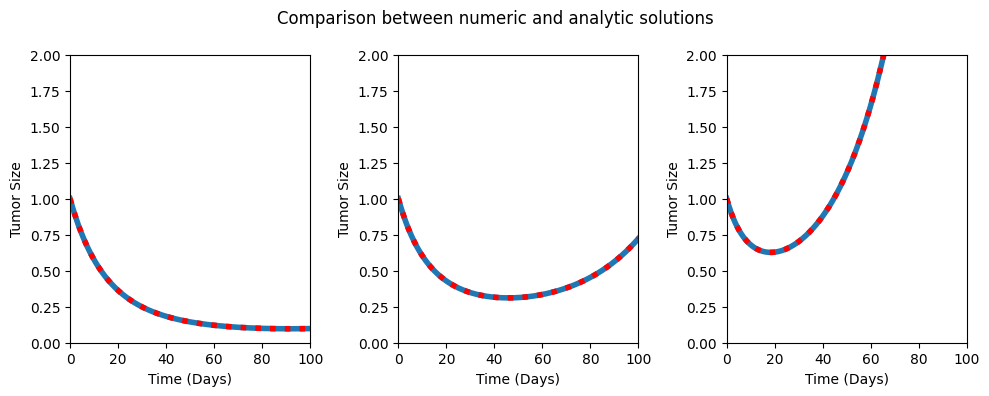

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for i, ax in enumerate(axs):
    params = {'lambda': lambda_vals[i], 'epsilon': epsilon_vals[i], 'V0': V0, 'gamma0': gamma0}
    model = GrowthInhibitionModel(params=params, method='Radau', dt = 0.11)
    model.simulate(t_max=t_max)
    model.plot(ax=ax, linewidth=4)
    
    t_vals = np.linspace(0, t_max, 100)
    V_vals = [analytic_tumor_values(V0, gamma0, lambda_vals[i], epsilon_vals[i], t) for t in t_vals]
    ax.plot(t_vals, V_vals, linewidth=4, linestyle=':', color='r')
    ax.set_ylim([0, 2]); ax.set_xlim(0, t_max)
    
plt.suptitle("Comparison between numeric and analytic solutions"); plt.tight_layout()